In [2]:
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
from ase.io import read
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pymatgen.io.cif")
warnings.filterwarnings("ignore", category=UserWarning, module="ase.io.cif")
import multiprocessing as mp
from functools import partial

## Download CoREMOF2019 database

In [ ]:
## download and extract CoREMOF 2019 dataset from MOFXDB(https://mof.tech.northwestern.edu/databases)
!wget https://mof.tech.northwestern.edu/Datasets/CoREMOF%202019-mofdb-version:dc8a0295db.zip -O ./raw_data/CoREMOF_2019-mofdb-version:dc8a0295db.zip
!unzip -o ./raw_data/CoREMOF_2019-mofdb-version:dc8a0295db.zip -d ./raw_data/CoREMOF2019

## TSD&SSD processing

In [23]:
ssd_csv = "./raw_data/Nandy_2022_SciData/separate_files/solvent_removal_stability/full_SSD_data.csv"
tsd_csv = "./raw_data/Nandy_2022_SciData/separate_files/thermal_stability/full_TSD_data.csv"
saved_dir = Path("./CGCNN_MT/data/")
src_cif_dir = Path("./raw_data/CoREMOF2019")

In [24]:
df_ssd = pd.read_csv(ssd_csv)
df_tsd = pd.read_csv(tsd_csv)
df_ssd.dropna(inplace=True)
df_tsd.dropna(inplace=True)
print(df_ssd.shape)
print(df_tsd.shape)
print(df_ssd.columns)
print(df_tsd.columns)
df_ssd.head()

(2179, 189)
(3132, 189)
Index(['CoRE_name', 'refcode', 'doi', 'assigned_solvent_removal_stability',
       'ANN_predicted_solvent_removal_stability', 'ANN_prediction_probability',
       'ANN_LSE', 'partition', 'Df (Å)', 'Di (Å)',
       ...
       'D_func-S-1-all', 'D_func-S-2-all', 'D_func-S-3-all',
       'explicit_intro_in_paper', 'number_of_sentences_in_paper',
       'sentence_indices', 'collapse_keywords', 'solvent_keywords',
       'stability_keywords', 'sentences'],
      dtype='object', length=189)
Index(['CoRE_name', 'refcode', 'doi', 'assigned_T_decomp (°C)',
       'ANN_predicted_T_decomp (°C)', 'ANN_LSD_10NN', 'ANN_LSD_10NN_scaled',
       'partition', 'Df (Å)', 'Di (Å)',
       ...
       'D_func-S-1-all', 'D_func-S-2-all', 'D_func-S-3-all', 'TGA_points_T',
       'TGA_points_mass', 'explicit_intro_in_paper',
       'number_of_sentences_in_paper', 'sentence_indices', 'keywords',
       'sentences'],
      dtype='object', length=189)


,CoRE_name,refcode,doi,assigned_solvent_removal_stability,ANN_predicted_solvent_removal_stability,ANN_prediction_probability,ANN_LSE,partition,Df (Å),Di (Å),...,D_func-S-1-all,D_func-S-2-all,D_func-S-3-all,explicit_intro_in_paper,number_of_sentences_in_paper,sentence_indices,collapse_keywords,solvent_keywords,stability_keywords,sentences
0,ABAVIJ_clean,ABAVIJ,10.1039/b404485a,1.0,1.0,0.943282,0.001705,train,2.49720,4.45543,...,0.000000,0.000000,0.00,True,176.0,"[60, 66]","[None, None]","[['desolv'], ['solvate', 'desolv', 'lose']]","[['retain'], ['retain']]",['Single crystals of 1 appeared to retain thei...
1,ABAYIO_clean,ABAYIO,10.1021/acs.cgd.6b00776,1.0,1.0,0.920237,0.001713,train,4.31822,11.38838,...,0.000000,0.000000,0.00,True,359.0,"[142, 143]","[None, None]","[['remov', 'water'], ['activat']]","[['porosity'], [' stable']]",['The porosity of 1 calculated by PLATON(31) i...
2,ABESUX_clean,ABESUX,10.1021/ic200345j,1.0,1.0,0.926693,0.001737,train,4.42071,5.87733,...,0.000000,0.000000,0.00,True,379.0,"[159, 167, 268, 156]","[None, None, None, None]","[['diamine'], ['diamine'], ['diamine'], ['H2O'...","[[' stable'], ['stability'], [' stable'], [' s...",['(24-28) It is noteworthy that in our neutral...
3,ABETAE_clean,ABETAE,10.1021/ic200345j,1.0,1.0,0.926645,0.001737,train,4.42278,5.88004,...,0.000000,0.000000,0.00,True,379.0,"[159, 167, 268, 156]","[None, None, None, None]","[['diamine'], ['diamine'], ['diamine'], ['H2O'...","[[' stable'], ['stability'], [' stable'], [' s...",['(24-28) It is noteworthy that in our neutral...
4,ABEXEM_clean,ABEXEM,10.1021/ic201013v,0.0,0.0,0.089531,0.001667,train,4.14331,4.82084,...,-0.013333,-0.013333,-0.02,True,646.0,"[128, 191]","[['collaps'], ['amorph']]","[['remov'], ['water']]","[None, [' stable', 'crystallinity']]",['The single crystals of 2-Ln suffer a progres...


In [25]:
select_cols1 = ["CoRE_name", "assigned_solvent_removal_stability", "partition"]
select_cols2 = ["CoRE_name", "assigned_T_decomp (°C)", "partition"]
feat_cols = df_ssd.loc[:, "Df (Å)":"D_func-S-3-all"].columns.tolist()
std_cols = ["MofName", "Label", "Partition"] + feat_cols
df_ssd = df_ssd[select_cols1 + feat_cols]
df_ssd.columns = std_cols
df_tsd = df_tsd[select_cols2 + feat_cols]
df_tsd.columns = std_cols

In [26]:
df_tsd["Partition"].unique()

array(['train', 'val', 'test'], dtype=object)

In [27]:
all_cifs = src_cif_dir.glob('*.cif')
all_cif_names = [cif.stem for cif in all_cifs]

print(len(all_cif_names))

print(len(df_ssd))
print(len(df_tsd))

print(df_ssd['MofName'].isin(all_cif_names).sum())
print(df_tsd['MofName'].isin(all_cif_names).sum())


12020
2179
3132
2179
3132


0/2179
500/2179
1000/2179
1500/2179
2000/2179


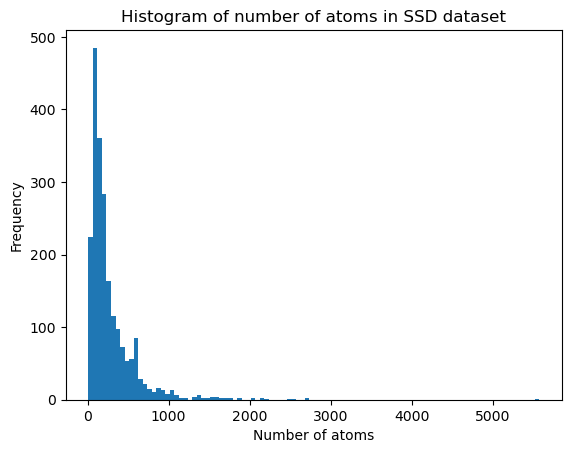

0/3132
500/3132
1000/3132
1500/3132
2000/3132
2500/3132
3000/3132


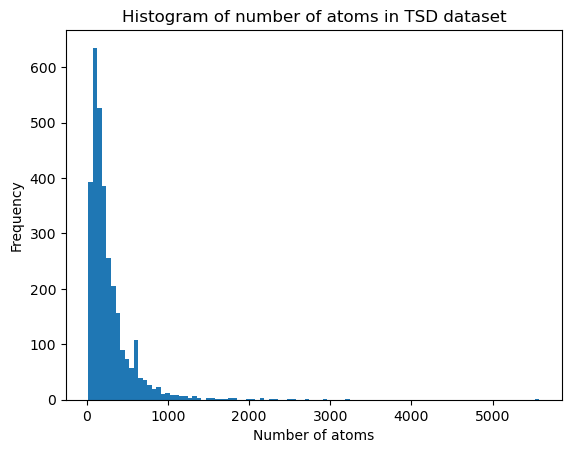

In [28]:
def get_atom_num(cif_file):
    atoms = read(cif_file)
    return len(atoms)

for df, task in zip([df_ssd, df_tsd], ["SSD", "TSD"]):
    task_dir =saved_dir/task
    cif_dir = task_dir/"cifs"
    # cif_dir.mkdir(exist_ok=True, parents=True)
    df.to_csv(task_dir/"id_prop_feat.csv", index=False)
    for i, row in df.iterrows():
        cif_file = str(cif_dir/f"{row['MofName']}.cif")
        src_cif_file = str(src_cif_dir/f"{row['MofName']}.cif")
        # shutil.copyfile(src_cif_file, cif_file)
        ## clean cif file
        # overlap_removal(src_cif_file, cif_file) # Input CIF should have P1 symmetry.
        # solvent_removal(cif_file, cif_file)
        if i%500==0:
            print(f"{i}/{len(df)}")
    
    with mp.Pool(processes=48) as pool:
        atom_num_list = pool.map(get_atom_num, cif_dir.glob("*.cif"))

    plt.hist(atom_num_list, bins=100)
    plt.xlabel('Number of atoms')
    plt.ylabel('Frequency')
    plt.title(f"Histogram of number of atoms in {task} dataset")
    plt.show()

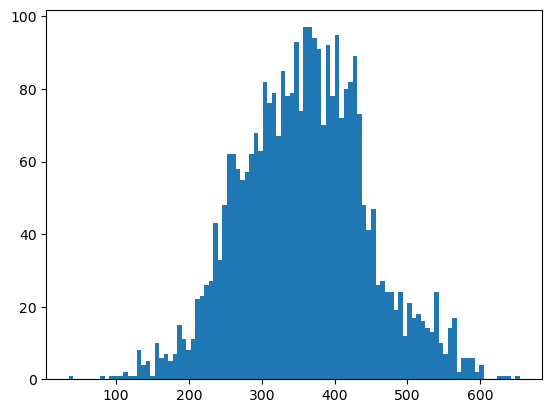

In [19]:
plt.hist(df_tsd['Label'], bins=100)
plt.show()

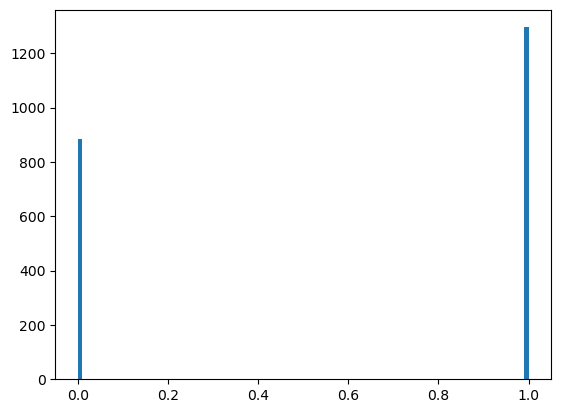

In [20]:
plt.hist(df_ssd['Label'], bins=100)
plt.show()

### Reneragete zeo++ and RACs features for TSD and SSS datasets.

In [ ]:
from CGCNN_MT.datamodule import clean_cif
import subprocess

## clean cifs
for task in  ["SSD", "TSD"]:
    task_dir =saved_dir/task
    cif_dir = task_dir/"cifs"
    output_dir = task_dir/"clean_cifs"
    clean_cif.main(cif_dir, output_dir, log_file=task_dir/"clean_cif.log", santize=True, n_cpus=1)

## generate features
for task in  ["SSD", "TSD"]:
    task_dir =saved_dir/task
    clean_cif_dir = task_dir/"clean_cifs"
    output_dir = task_dir/"features"
    work_dir = Path("./ML/featuring")
    process = subprocess.Popen(
        f"python {work_dir/'feature_generation.py'} --cif_dir {clean_cif_dir} --prob_radius 1.86",
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        shell=True,
        env=os.environ.copy(),
        cwd=str(work_dir)
    )

In [21]:
## merge with id_prop_feat.csv
df_ssd_new = pd.read_csv('./CGCNN_MT/data/SSD/RAC_and_zeo_features.csv')
df_tsd_new = pd.read_csv('./CGCNN_MT/data/TSD/RAC_and_zeo_features.csv')

print(df_ssd_new.shape)
print(df_tsd_new.shape)

df_ssd = pd.read_csv('./CGCNN_MT/data/SSD/id_prop_feat.csv')
df_tsd = pd.read_csv('./CGCNN_MT/data/TSD/id_prop_feat.csv')

print(df_ssd.shape)
print(df_tsd.shape)

df_ssd_new.drop(columns=['cif_file'], inplace=True)
df_tsd_new.drop(columns=['cif_file'], inplace=True)
df_ssd_new.rename(columns={'name': 'MofName'}, inplace=True)
df_tsd_new.rename(columns={'name': 'MofName'}, inplace=True)

df_ssd_new = df_ssd[["MofName", "Label", "Partition"]].merge(df_ssd_new, on="MofName", how="right")
df_tsd_new = df_tsd[["MofName", "Label", "Partition"]].merge(df_tsd_new, on="MofName", how="right")

df_ssd_new.to_csv('./CGCNN_MT/data/SSD/RAC_and_zeo_features_with_id_prop.csv', index=False)
df_tsd_new.to_csv('./CGCNN_MT/data/TSD/RAC_and_zeo_features_with_id_prop.csv', index=False)

print(df_ssd_new.shape)
print(df_tsd_new.shape)

(2178, 192)
(3131, 192)
(2179, 177)
(3132, 177)
(2178, 193)
(3131, 193)


## prepare graph data

In [21]:
from CGCNN_MT.datamodule.prepare_data import make_prepared_data
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pymatgen.io.cif")

In [ ]:
## generate features
for task in  ["SSD", "TSD"]:
    task_dir =saved_dir/task
    clean_cif_dir = task_dir/"clean_cifs"
    with mp.Pool(processes=32) as pool:
        pool.map(partial(make_prepared_data, root_dataset_total=clean_cif_dir, radius=8, max_num_nbr=10), clean_cif_dir.glob("*.cif"))
        for cif_file in tqdm(list(clean_cif_dir.glob("*.cif"))):
            g_file_name = cif_file.stem + ".graphdata"
            if (clean_cif_dir/g_file_name).exists():
                continue
            else:
                flag = make_prepared_data(cif_file, clean_cif_dir, radius=8, max_num_nbr=10)
                if not flag:
                    print(f"Failed to generate graph data for {cif_file}")
                    continue